In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

In [26]:
FILE = "lattice_in.h5"
DATASET = "DS1"

In [27]:
def generate_perlin_noise_2d(shape, res):
    def f(t):
        return 6*t**5 - 15*t**4 + 10*t**3

    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    grid = np.mgrid[0:res[0]:delta[0], 0:res[1]:delta[1]].transpose(1, 2, 0) % 1
    # Gradients
    angles = 2*np.pi*np.random.rand(res[0]+1, res[1]+1)
    gradients = np.dstack((np.cos(angles), np.sin(angles)))
    g00 = gradients[0:-1, 0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g10 = gradients[1:, 0:-1].repeat(d[0], 0).repeat(d[1], 1)
    g01 = gradients[0:-1, 1:].repeat(d[0], 0).repeat(d[1], 1)
    g11 = gradients[1:, 1:].repeat(d[0], 0).repeat(d[1], 1)
    # Ramps
    n00 = np.sum(grid * g00, 2)
    n10 = np.sum(np.dstack((grid[:, :, 0]-1, grid[:, :, 1])) * g10, 2)
    n01 = np.sum(np.dstack((grid[:, :, 0], grid[:, :, 1]-1)) * g01, 2)
    n11 = np.sum(np.dstack((grid[:, :, 0]-1, grid[:, :, 1]-1)) * g11, 2)
    # Interpolation
    t = f(grid)
    n0 = n00*(1-t[:, :, 0]) + t[:, :, 0]*n10
    n1 = n01*(1-t[:, :, 0]) + t[:, :, 0]*n11
    return np.sqrt(2)*((1-t[:, :, 1])*n0 + t[:, :, 1]*n1)

Average flow (0.04, 0.00) m/s
Variance in flow (0.00, 0.00) m/s


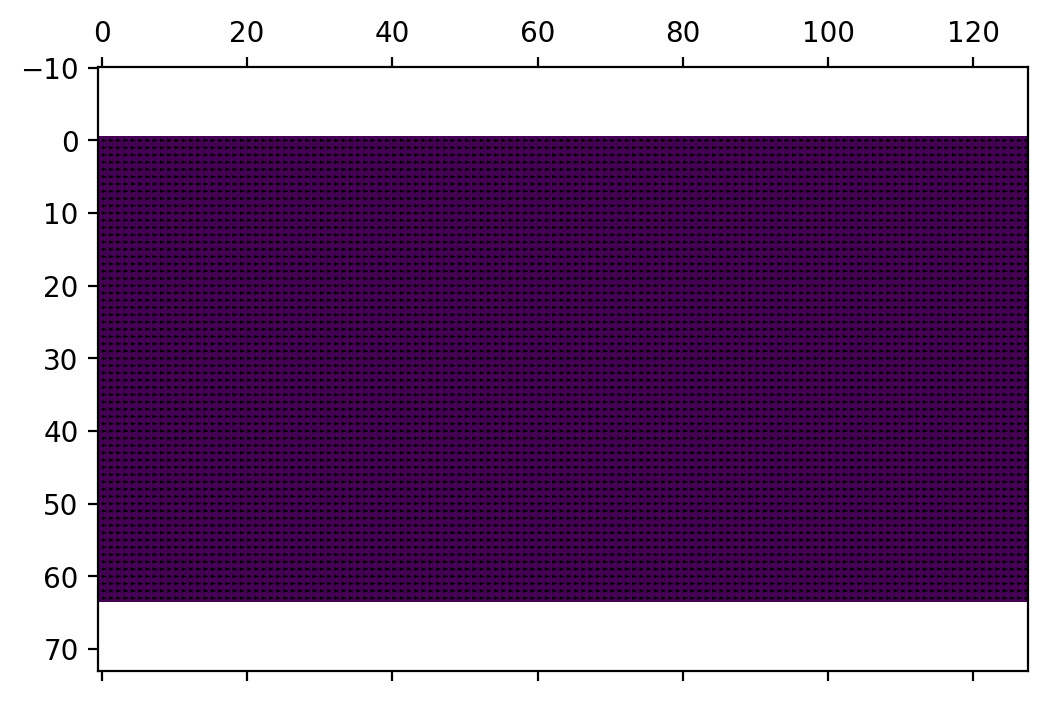

In [35]:
noise, octaves = 0, 6
persistence = 0.3
frequency, amplitude = 1, 0
for _ in range(octaves):
    noise += amplitude * generate_perlin_noise_2d((64, 128), (frequency*1, frequency*2))
    frequency *= 2
    amplitude *= persistence

u, v = np.gradient(noise)
u += 4E-02

print(f'Average flow ({np.mean(u):.2f}, {np.mean(v):.2f}) m/s')
print(f'Variance in flow ({np.std(u):.2f}, {np.std(v):.2f}) m/s')

types = np.ones_like(u, dtype=int)
types[0, :] = 2
types[-1, :] = 2

r = np.ones_like(u)

vel = np.sqrt(u**2 + v**2)

fig, ax = plt.subplots(dpi=200)
# ax.matshow(noise, label='perlin noise')
ax.matshow(r, label='Density')
ax.quiver(u, v)
ax.axis('equal')
plt.show()

In [34]:
initial = {
    'vel_x'  : u,
    'vel_y'  : v,
    'density': r
}

with h5py.File(FILE, 'w') as file:
    group = file.create_group('initial')
    for name, data in initial.items():
        dataset = group.create_dataset(name, data.shape, dtype='f')
        dataset[...] = data

    dataset = file.create_dataset('types', types.shape, dtype='i')
    dataset[...] = types

1.0


In [37]:
with h5py.File(FILE, 'r') as file:
    print(file['initial/density'][:10])


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


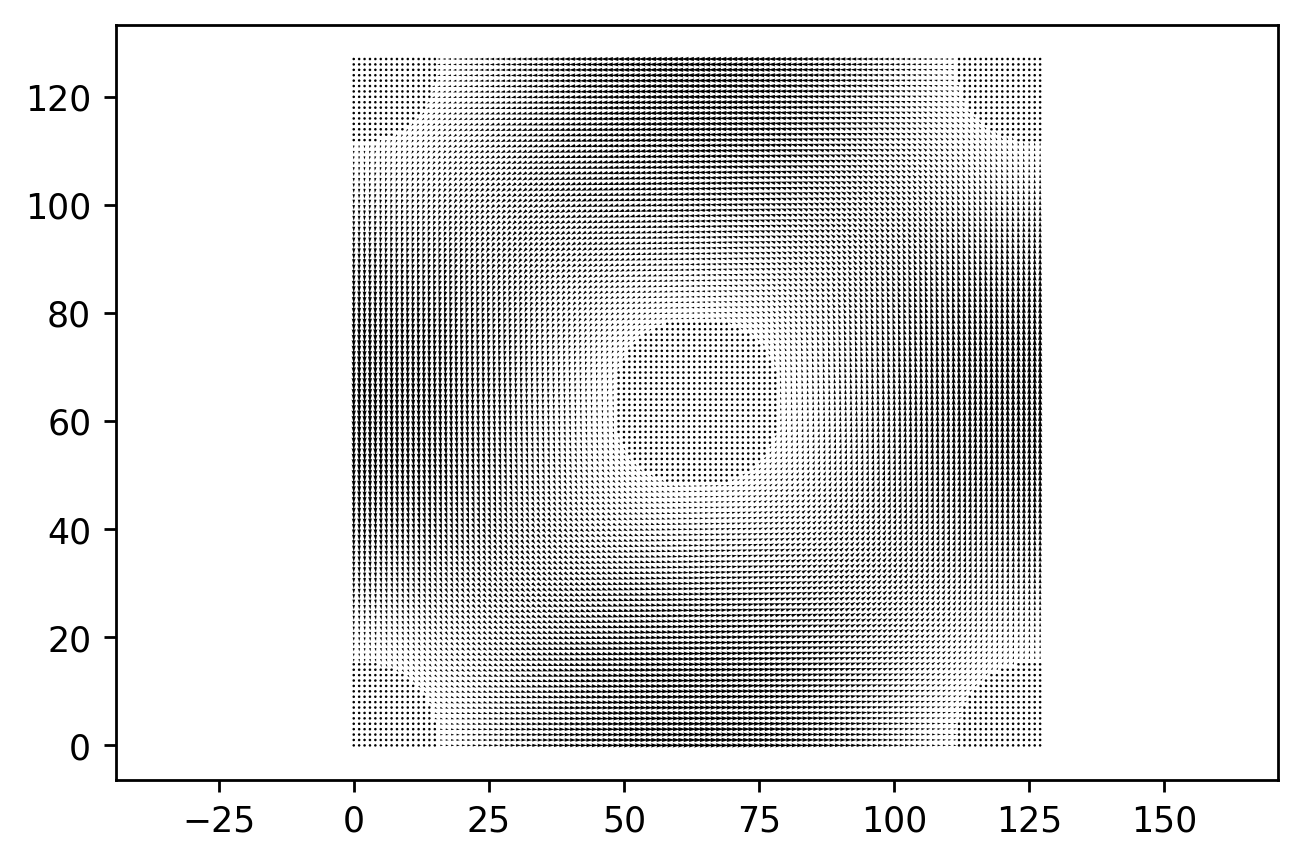

In [76]:
resolution = 128
x = np.linspace(0, np.pi, resolution)
y = x[..., np.newaxis]

u =  0.02 * np.sin(x) * np.cos(y)
v = -0.02 * np.cos(x) * np.sin(y)
r =  np.ones_like(u)

types = np.ones_like(u, dtype=int)

types[:,  0] = 1 << 2
types[:, -1] = 1 << 2

types[ 0, :] = 1 << 3
types[-1, :] = 1 << 3

types[ 0,  0] = 1 << 1
types[-1, -1] = 1 << 1
types[ 0, -1] = 1 << 1
types[-1,  0] = 1 << 1

_, ax = plt.subplots(dpi=250)
ax.quiver(u, v)
ax.axis('equal')
plt.show()


In [77]:
initial = {
    'vel_x'  : u,
    'vel_y'  : v,
    'density': r
}

with h5py.File('taylor_green.h5', 'w') as file:
    group = file.create_group('initial')
    for name, data in initial.items():
        dataset = group.create_dataset(name, data.shape, dtype='f')
        dataset[...] = data

    dataset = file.create_dataset('types', types.shape, dtype='i')
    dataset[...] = types


In [78]:
with h5py.File('taylor_green.h5', 'r') as file:
    print(file['types'])

<HDF5 dataset "types": shape (128, 128), type "<i4">
